# geohackweek 2016

## DAY 3, NOV 16

<img src="../../img/ndarray_icon.png" width = "70" align ="left">
### multidimensional array analysis

<br>

#### Instructors: A. Arendt, J. Hamman


### Overview:

Geoscientists often need to manipulate datasets structured as arrays. A common example is gridded data consisting of a set of climate variables (e.g. temperature and precipitation) that varies in space and time. Often we need to subset a large global dataset to look at data for a particular region, or select a specific time slice. Then we might want to apply statistical functions to these subsetted groups to generate summary information.

The tools in this tutorial have some similarity to raster image processing tools. Both require computational engines that can manipulate large stacks of data formatted as arrays. Here we focus on tools that are optimized to handle data that have many variables spanning dimensions of time and space. See the raster tutorials for tools that are optimized for image processing tools and remote sensing datasets.

### Existing Methods:

A common approach for handling multidimensional grids is to read the data into an array and then write a series of nested loops with conditional statements to look for a specific range of index values associated with the temporal or spatial slice needed. Also, clever use of matrix algebra is often used to summarize data across spatial and temporal dimensions.

Many multidimensional datasets are stored in self-describing formats such as netcdf. Some organizations have developed their own netcdf toolkits that accomplish tasks like subsetting and grouping.

### Challenges:

Many multidimensional datasets are becoming very large as model resolution and sensing capabilities improve. Traditional methods for looping through array datasets to perform subsetting are no longer viable options for handling these large datasets, because we are limited by what our computers can read into memory. In addition, it is often challenging to keep track of index values when manipulating arrays that span multiple dimensions. 

### Learning Objectives: 

To become familiar with the [xarray](http://xarray.pydata.org/en/stable/) Python library for:
1. selection and subsetting of array datasets using labeled indexing;
2. grouping data and applying statistical functions across multiple dimensions;
3. visualizing 1 and 2 dimensional slices of array data;
4. using multi-threading libraries to facilitate manipulation of larger-than-memory grids;
5. understand best practices for reading and storing large gridded datasets.

### What is xarray?

* originally developed by employees (Stephan Hoyer, Alex Kleeman and Eugene Brevdo) at [The Climate Corporation](https://climate.com/)
* xaray extends some of the core functionality of Pandas:
    * operations over _named_ dimensions
    * selection by label instead of integer location
    * powerful groupby functionality
    * database-like joins

### When to use xarray:

* if your data are multidimensional (e.g. climate data: x, y, z, time)
* if your data are structured on a regular grid
* if you can represent your data in NetCDF format



### Why not just numpy?
* joining arrays is awkward in numpy
* labeling is limited to index position
* arrays must be small enough to fit into memory

### Basic xray data structures:
* Dataset: multi-dimensional equivalent of a Pandas DataFrame
    * dict-like container of DataArray objects
![climate](http://xray.readthedocs.org/en/stable/_images/dataset-diagram.png)
* dimensions (x, y, time); variables (temp, precip); coords (lat, long); attributes

### File formats
* xarray exclusively works with Network Common Data Form or [NetCDF](http://www.unidata.ucar.edu/software/netcdf/) files
* NetCDF files:
    * are self-describing (file layout is described in the header)
    * store data arrays as well as associated metadata
    * allow use of Hierarchical Data Format (HDF) files (after version 4.0)
    * note: different NetCDF versions can impact [reading of data](http://xarray.pydata.org/en/stable/io.html) in xarray

### Begin by importing the relevant libraries:

In [1]:
%matplotlib inline 
import boto3
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray
import xarray.ufuncs as xu 
import seaborn as sn
from datetime import datetime
from dask.diagnostics import ProgressBar

C:\Users\Anthony Arendt\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Sample datasets:

* we will use climate reanalysis data from the European Center for Medium Range Weather Forecasts [ECMWF](http://www.ecmwf.int/)
* as is the case for many climate products, the process involves downloading large netcdf files to a local machine
* this example follows and expands from xarray developer Stephan Hoyer's [blog post](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python)

### DATASET ACCESS

The data can be accessed on the geohack2016 AWS s3 bucket: ecmwf_airtemp.nc.

(NOTE: I suggest we post all project data to s3. We can provide the url and encourage students to access this way through Python. This will require distributing AWS security keys on DAY 1).

In [5]:
s3 = boto3.resource('s3')
s3.Bucket(name='geohack2016').download_file('ecmwf_airtemp.nc','ecmwf_airtemp.nc')

### Open the dataset

First we [open](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) the data and load it into a *data array*. (Note: the choice of engine depends on the format of the netcdf file).

In [2]:
ds = xarray.open_dataset(r'c:/work/mnt/ecmwf/ecmwf_airtemp.nc', engine = 'scipy')

You'll notice this seemed to go very fast. That is because this step does not actually ask Python to read the data into memory. Rather, Python is just scanning the contents of the file. This is called _lazy evaluation_. 

### Inspect the Dataset contents:

You can always remember what xarray has stored in each of your datasets simply by typing the variable name. 

In [3]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 13361)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
Data variables:
    t2m        (time, latitude, longitude) float64 242.0 242.0 242.0 242.0 ...
Attributes:
    history: 2015-10-19 21:11:12 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls05-a562cefde8a29a7288fa0b8b7f9413f7-1hbxws.target -o /data/data04/scratch/netcdf-atls05-a562cefde8a29a7288fa0b8b7f9413f7-y_OM5J.nc -utime
    Conventions: CF-1.0

In [4]:
ds.data_vars

Data variables:
    t2m      (time, latitude, longitude) float64 242.0 242.0 242.0 242.0 ...

## Dataset Properties

Xarray datasets have a number of [properties](http://xarray.pydata.org/en/stable/data-structures.html#dataarray) that you can view at any time:

### Dimensions

Dimension are the names of each of the dimensional axes:

In [8]:
ds.dims

Frozen(SortedKeysDict({'time': 13361, 'latitude': 241, 'longitude': 480}))

## Coordinates
Think of coordinates as the labels for all elements along each dimension. So dimensions are the names of your axes, whereas coordinates are the values of all the ticks along those axes: 


In [9]:
ds.coords

Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...

### Attributes

Attributes are metadata associated with the dataset. It's very good practice to keep track of the details of your data this way. Here we are just reading back the attribute data already stored in the climate data netcdf file. Note that all of these dataset properties are returned as Python dictionaries.

In [11]:
ds.attrs

OrderedDict([('Conventions', 'CF-1.0'),
             ('history',
              '2015-10-19 21:11:12 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls05-a562cefde8a29a7288fa0b8b7f9413f7-1hbxws.target -o /data/data04/scratch/netcdf-atls05-a562cefde8a29a7288fa0b8b7f9413f7-y_OM5J.nc -utime')])

### Data Arrays

So far we have looked at the xarray data type called a "dataset". An xarray dataset is a collection of all the elements in this graphic:
<br>
![datasetExample](http://xray.readthedocs.org/en/stable/_images/dataset-diagram.png)

We have queried the dataset details about our datset's dimensions, coordinates and attributes. Next we will look at the variable data contained within the dataset. In the graphic above, there are two variables (temperature and precipitation). In xarray, these observations get stored as a "data array", which is similar to a conventional array you would find in numpy or matlab. Let's look again at our dataset and extract some data arrays:

In [15]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 13361)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
Data variables:
    t2m        (time, latitude, longitude) float64 242.0 242.0 242.0 242.0 ...
Attributes:
    Conventions: CF-1.0
    history: 2015-10-19 21:11:12 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls05-a562cefde8a29a7288fa0b8b7f9413f7-1hbxws.target -o /data/data04/scratch/netcdf-atls05-a562cefde8a29a7288fa0b8b7f9413f7-y_OM5J.nc -utime

Here we see that the "data variables" include "t2m", which is the air temperature at 2 m height. We can isolate the t2m "data cube" as follows: 

In [16]:
ds.t2m

<xarray.DataArray 't2m' (time: 13361, latitude: 241, longitude: 480)>
[1545600480 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
Attributes:
    units: K
    long_name: 2 metre temperature

This returns a "data array". Note that the associated coordinates and attributes get carried along for the ride. Also note that we are still not reading any data into memory. 

# Indexing

Indexing is used to select specific elements from xarray files. Let's manipulate the coordinate data array to try some examples, because it is a simple one dimensional array.

We begin by extracting a data array from the dataset coordinates. Let's work with the 'time' coordinate: 

In [20]:
ds.coords['time']

<xarray.DataArray 'time' (time: 13361)>
array(['1978-12-31T22:00:00.000000000-0800',
       '1979-01-01T22:00:00.000000000-0800',
       '1979-01-02T22:00:00.000000000-0800', ...,
       '2015-07-28T23:00:00.000000000-0700',
       '2015-07-29T23:00:00.000000000-0700',
       '2015-07-30T23:00:00.000000000-0700'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
Attributes:
    long_name: time

Now we will select some elements from the time array. You are probably already used to conventional ways of indexing an array using integers. Here's how that's done in xarray (it's called [positional indexing](http://xarray.pydata.org/en/stable/indexing.html)):

In [26]:
ds.coords['latitude'].isel(latitude=0)

<xarray.DataArray 'latitude' ()>
array(90.0, dtype=float32)
Coordinates:
    latitude  float32 90.0
Attributes:
    long_name: latitude
    units: degrees_north

In [25]:
ds.coords['latitude'].isel(latitude=slice(0,10))

<xarray.DataArray 'latitude' (latitude: 10)>
array([ 90.  ,  89.25,  88.5 ,  87.75,  87.  ,  86.25,  85.5 ,  84.75,
        84.  ,  83.25], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 84.75 ...
Attributes:
    long_name: latitude
    units: degrees_north

### Data Arrays
* when we index a specific variable, it returns a Data Array:

## Indexing: positional, by integer
* xray supports indexing by position and by labeled dimensions 
* positional indexing: similar to numpy arrays
* note: attributes persist through the indexing operation

In [27]:
ds.t2m[:,0,0]

<xarray.DataArray 't2m' (time: 13361)>
array([ 241.95071989,  255.62538883,  248.00456772, ...,  274.85110101,
        275.06312703,  274.81475369])
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
    latitude   float32 90.0
    longitude  float32 0.0
Attributes:
    units: K
    long_name: 2 metre temperature

## Plot: temperature at one grid cell
* data are extracted to a variable as a numpy array

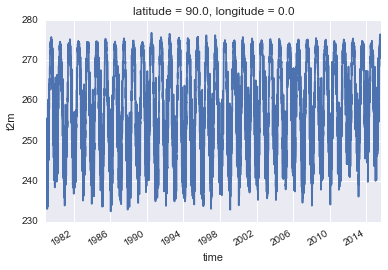

In [28]:
ds.t2m[:,0,0].plot()

## Indexing: positional, by label
* use variable label for the index location (Pandas-like)

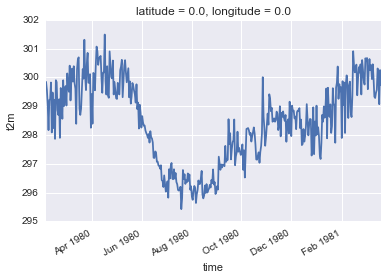

In [29]:
ds.t2m.loc['1980-02-04':'1981-03-21',0,0].plot()

## Indexing: Labeled dimensions
* no need to rely on dimension order
* method 1:
    * use a dictionary as the argument for positional array indexing (numpy-like)

In [32]:
ds.t2m[dict(time=slice(0,100),latitude=slice(50,55),longitude=slice(10,12))];

## Indexing: Labeled dimensions
* method 2:
    * use a dictionary as the argument for label-based array indexing (Pandas-like)

In [34]:
ds.t2m.loc[dict(time=slice("1992-01-02","1993-09-25"),
                latitude=slice(52.5,49.5),longitude=slice(7.5,8.25))];

## Indexing: Labeled dimensions
* this syntax is beginning to get cumbersome
* xray has the following convenience methods to tidy up the syntax

In [ ]:
ds.t2m.isel(time=slice(0,100),latitude=slice(50,55),longitude=slice(10,12))

In [36]:
#ds.t2m.loc[dict(time=slice("1992-01-02","1993-09-25"),
#                latitude=slice(52.5,49.5),longitude=slice(7.5,8.25))]

ds.t2m.sel(time=slice("1992-01-02","1993-09-25"),
           latitude=slice(52.5,49.5),longitude=slice(7.5,8.25));

## Visualization of indexing applications
* a simple application: spatial subsetting (Alaska region)
* note: we need to [squeeze](http://xray.readthedocs.org/en/stable/generated/xray.DataArray.squeeze.html) the array for plotting purposes

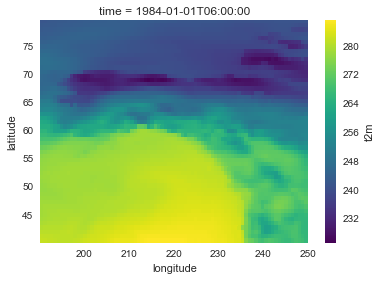

In [37]:
plotData = ds.sel(time="1984-01-01",latitude=slice(80,40)
                  ,longitude=slice(190,250))
plotData.squeeze(dim='time').t2m.plot()

## Indexing: pointwise
* all indexing so far has involved selection along orthogonal groups
* we can also provide lists to select individual points from the grids

In [38]:
times = pd.to_datetime(['1992-01-02T6:00:00','1992-01-02T6:00:00'])
ds.t2m.sel_points(time=times,latitude=[52.5,60.0],longitude=[7.5,8.25])

<xarray.DataArray 't2m' (points: 2)>
array([ 279.83472223,  271.96148919])
Coordinates:
    time       (points) datetime64[ns] 1992-01-02T06:00:00 1992-01-02T06:00:00
    longitude  (points) float32 7.5 8.25
    latitude   (points) float32 52.5 60.0
  * points     (points) int64 0 1
Attributes:
    units: K
    long_name: 2 metre temperature

### Dask:
* many multidimensional datasets are larger-than-memory
* xray recently integrated [Dask](http://xray.readthedocs.org/en/stable/dask.html)
* Dask: parallel computing through task scheduling and blocked algorithms
* from _fits in memory_ to _fits on disk_
![chunkGraphic](http://xray.readthedocs.org/en/stable/_images/dask_array.png)

### Dask:
* dask.array = numpy + threading
* dask.bag = map, filter, toolz + multiprocessing
* dask.dataframe = pandas + threading

![daskGraphic](http://dask.pydata.org/en/latest/_images/collections-schedulers.png)

![animation](http://mrocklin.github.com/blog/images/dask/embarrassing.gif)

## Opening multiple netcdf files, and using Dask
* we will use the [mfdataset](http://xray.readthedocs.org/en/stable/generated/xray.open_mfdataset.html#xray.open_mfdataset) option that opens multiple files as a single xray dataset
* this automatically invokes the dask functionality
* in our case, there are multiple files for each parameter

In [ ]:
ds = xray.open_mfdataset(r'c:/work/mnt/ecmwf/*.nc', engine='scipy')

## Dataset indexing
* indexing on datasets indexes all variables simulataneously

In [ ]:
ds.sel(time=slice("1992-01-02","1993-09-25"),
       latitude=slice(52.5,49.5),longitude=slice(7.5,8.25))

### Chunk sizes:
* in my testing, getting the chunk size right is the crucial step to optimize Dask
* without specifying chunk size, open_mfdataset chunks along existing dimensions

In [ ]:
ds.chunks

### Chunk size:
* recommended: follow the advice [here](http://xray.readthedocs.org/en/stable/dask.html?highlight=rechunk#chunking-and-performance) regarding chunk sizes: about 1 million elements
* in our case: 480* 241 = 115680
* so make the time chunk 10 to get around 1 million
* note: we're only chunking the time dimension. Choice depends on typical slicing scenarios. More testing needed!


In [ ]:
ds = xray.open_mfdataset(r'c:/work/mnt/ecmwf/*.nc', engine='scipy', chunks = {'time':10})

## GroupBy processing
* xray has powerful [GroupBy](http://xray.readthedocs.org/en/stable/groupby.html) processing tools
* this is similar to GROUP BY processing in SQL
* in all cases we **split** the data, **apply** a function to independent groups, and **combine** back into a known data structure

## GroupBy processing: example
* we often want to build a time series of change from spatially distributed data
* let's calculate the average air temperature over the globe for the full time period
* remember: split, apply, combine!

### Groupby processing: split

* we can groupby the name of a variable or coordinate
* this returns an xray groupby object

In [ ]:
ds.t2m.groupby('time')

View the group indices:

In [ ]:
ds.t2m.groupby('time').groups

* output looks like this:

{numpy.datetime64('1979-01-02T06:00:00.000000000+0000'): 1,

 numpy.datetime64('1989-03-15T06:00:00.000000000+0000'): 3726,

 numpy.datetime64('2006-03-29T06:00:00.000000000+0000'): 9949,
 
 numpy.datetime64('2004-04-16T06:00:00.000000000+0000'): 9237,

### Groupby processing: apply
* when providing a single dimension to the GroupBy command, xray applies the function across the remaining dimensions
* we could do this:

In [ ]:
def mean(x):
    return x.mean()

ds.t2m.groupby('time').apply(mean).plot()

* however, groupby objects have convenient shortcuts (see next slide)
* but, use this approach if the function is non-standard 

### Groupby processing: apply
* now an acutal calculation: 
    * we'll use dask's [diagnostic tools](http://dask.pydata.org/en/latest/diagnostics.html) to monitor the processing
    * we'll use xray's new [plotting](http://xray.readthedocs.org/en/stable/plotting.html) capabilities
    * when a single dimension is provided, xray applies the function over all dimensions _other than_ that dimension

In [ ]:
with ProgressBar():
    ds.t2m.groupby('time').mean().plot()

* we can group over any number of [time components](http://xray.readthedocs.org/en/stable/time-series.html#datetime-components)
* here's the global average annual air temperature since 1979 

In [ ]:
with ProgressBar():
    ds.t2m.groupby('time.year').mean().plot()

### Conversion to Pandas
* we can use ".to_series()" to convert an xray data array to a Pandas data series
* then, use Pandas methods on the series to resample the data

In [ ]:
with ProgressBar():
    ds.t2m.groupby('time').mean().to_series().resample('A',how='mean').plot()

### Groupby: advanced temporal grouping
* xray introduces the 'season' time component, common in climate studies
* and it turns out, xray's new [.plot()](http://xray.readthedocs.org/en/stable/plotting.html) functionality operates on spatial maps as well!

* here is the mean differences between summer and winter global temperatures

In [ ]:
ds_by_season = ds.t2m.groupby('time.season').mean('time')
t2m_range = abs(ds_by_season.sel(season='JJA')
                 - ds_by_season.sel(season='DJF'))
t2m_range.plot()

## Calculation of wind vectors

* xray exposes numpy [ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) commands that can operate on data arrays
* here we'll calculate windspeed from the orthogonal wind vectors

In [ ]:
subset = ds.sel(time="1984-01-01",latitude=slice(70,40),
                longitude=slice(200,240)).squeeze(dim='time')
windspeed = xu.sqrt(subset.u10**2+subset.v10**2)

In [ ]:
plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.gridlines()
X = windspeed.coords['longitude'].values
Y = windspeed.coords['latitude'].values
plt.pcolormesh(X,Y,windspeed.values,cmap='BrBG')
ax.quiver(X, Y, subset.u10.values, subset.v10.values)
plt.colorbar()

### Masking with WHERE:
* so far we have used indexing to return subsets of the original
* the subset array shape will be different from the original
* however, we often want to retain the array shape and mask out some observations
* applications: remote sensing, land cover modeling

### Masking with WHERE:
* question: which grid cells had temperatures > 12 C on June 21, 1984?
* we will use [where()](http://xray.readthedocs.org/en/stable/indexing.html#masking-with-where) for this selection

In [ ]:
subset = ds.sel(time="1984-06-21",latitude=slice(70,40),
                longitude=slice(200,240))
subset.t2m.where(subset.t2m > 285.15).plot()

### Masking with WHERE:
* a common Earth science application: creating land cover masks
* next we'll use the sea surface temperature field (sst) to build a land and ocean mask 
* we'll assign land a value of 1, and ocean a value of 2 (arbitrary)

### Land/ocean mask
* the sst field currently has NaN for all land surfaces:

In [ ]:
subset = ds.sel(latitude=slice(70,40),longitude=slice(200,240)) # Alaska subset
subset.sst.isel(time=0).plot()

### Buliding the mask:
* here we'll use some lower-level numpy commands to build the mask
* mask number depends on whether the cells are finite or NaN

In [ ]:
maskOcean = 2 * np.ones((subset.dims['latitude'],
                         subset.dims['longitude'])) \
                        * np.isfinite(subset.sst.isel(time=0))  

maskLand = 1 * np.ones((subset.dims['latitude'],
                        subset.dims['longitude'])) \
                        * np.isnan(subset.sst.isel(time=0))  

maskArray = maskOcean + maskLand

### Mask as Coordinates
* we can keep the mask as a separate array entity
* or, if we are using it routinely, there are advantages to [adding it](http://xray.readthedocs.org/en/stable/data-structures.html#dataarray-coordinates) as a coordinate to the data array

In [ ]:
subset.coords['mask'] = (('latitude','longitude'),maskArray)
subset

* Here's a visualization of the land/ocean mask

In [ ]:
subset.mask.plot()

### Mask as Coordinates
* now we can easily apply the mask using where()
* we can integrate this with statistical functions operating on the array

* this is the mean air temperature over Alaska during the entire period of record

In [ ]:
subset.t2m.mean('time').where(subset.mask == 1).plot()

In [ ]:
 ds.temperature.groupby('time').mean().plot()

* similarly, this is the mean SST over the full time series

In [ ]:
subset.sst.mean('time').where(subset.mask == 2).plot()

### Calculating a climate index:
* climate scientists commonly calculate mean diferences in sea and land surface temperatures
* question: what is the mean annual difference in SST and t2m over the Alaska region? 

In [ ]:
landSft = subset.t2m.where(subset.mask == 1).groupby('time.year').mean()
oceanSft = subset.sst.where(subset.mask == 2).groupby('time.year').mean()
landSft

* here's a plot of the index, showing mean annual differences in land/ocean

In [ ]:
climateIndex = (landSft - oceanSft).plot()

### Groupby on two dimensional mask?
* our mask is 2D (lat, long)
* wouldn't it be useful to groupby this mask directly? 
* this would be more elegant than above, and add some additional flexibility

In [ ]:
subset.t2m.groupby('mask').mean()

* if we run this, there are errors
* the xray team is working on removing the 1-D limitation on groupby operations
* stay tuned!

### a trick to handle > 1-D 
* create one dimensional arrays of coordinate values
* pass these to the .sel_points method
* this is slow, but it works

In [ ]:
lonVec = subset.coords['longitude'].where(subset.mask == 2).values
lonVec = lonVec[np.isfinite(lonVec)]
latVec = subset.coords['latitude'].where(subset.mask == 2).values
latVec = latVec[np.isfinite(latVec)]

In [ ]:
subset.isel(time=0).sel_points(longitude=lonVec, latitude=latVec, dim='points').t2m.mean(['points']).values

### more examples:
* an example combining multiple parameters within the same dataframe

In [ ]:
(subset.t2m + subset.u10 / 2.3 - subset.v10 * 1.2).groupby('time.month').mean().plot()

In [ ]:
ds.isel(time=0).plot()